In [1]:
!pip install transformers --quiet
!pip install opendatasets --quiet

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aarishalam
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 47.1MB/s]

In [3]:
import torch

In [4]:
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Avaiable Device: ",device)

Avaiable Device:  cuda


In [6]:
data_df = pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
data_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)

In [10]:
data_df.shape

(26708, 3)

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26708 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26708 non-null  object
 1   headline      26708 non-null  object
 2   is_sarcastic  26708 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 834.6+ KB


In [13]:
data_df.drop('article_link',inplace=True,axis=1)

In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26708 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26708 non-null  object
 1   is_sarcastic  26708 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [35]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df['headline']), np.array(data_df['is_sarcastic']), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [36]:
print("Training Size: ",X_train.shape)
print("Validation Size: ",X_val.shape)
print("Testing Size: ",X_test.shape)

Training Size:  (18695,)
Validation Size:  (4006,)
Testing Size:  (4007,)


In [45]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [46]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x,
                            max_length = 100,
                            truncation = True,
                            padding = 'max_length',
                            return_tensors='pt').to(device)
                  for x in X
                 ]

        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [47]:
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4

In [48]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [49]:
class MyModel(nn.Module):
    def __init__(self, bert):

        super(MyModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output


In [50]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

In [51]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

In [52]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for indx, data in enumerate(train_dataloader):
        input, label = data

        input.to(device)
        label.to(device)

        prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)


        batch_loss = criterion(prediction, label)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()


            acc = ((prediction).round() == label).sum().item()

            total_acc_val += acc


    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/100, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/100:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2606 Train Accuracy: 80.0588 Validation Loss: 0.4796 Validation Accuracy: 83.8492
Epoch no. 2 Train Loss: 0.2119 Train Accuracy: 84.4985 Validation Loss: 0.4493 Validation Accuracy: 85.4968
Epoch no. 3 Train Loss: 0.1985 Train Accuracy: 85.5790 Validation Loss: 0.4207 Validation Accuracy: 85.8462
Epoch no. 4 Train Loss: 0.1911 Train Accuracy: 85.9107 Validation Loss: 0.4296 Validation Accuracy: 85.6715
Epoch no. 5 Train Loss: 0.1873 Train Accuracy: 86.3546 Validation Loss: 0.4340 Validation Accuracy: 84.9476
Epoch no. 6 Train Loss: 0.1837 Train Accuracy: 86.3386 Validation Loss: 0.4124 Validation Accuracy: 85.9960
Epoch no. 7 Train Loss: 0.1817 Train Accuracy: 86.5312 Validation Loss: 0.4232 Validation Accuracy: 85.5467
Epoch no. 8 Train Loss: 0.1802 Train Accuracy: 86.8200 Validation Loss: 0.4101 Validation Accuracy: 86.1208
Epoch no. 9 Train Loss: 0.1784 Train Accuracy: 86.8200 Validation Loss: 0.4021 Validation Accuracy: 86.5701
Epoch no. 10 Train Loss: 0.1

In [53]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(testing_dataloader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_val = criterion(prediction, label)
    total_loss_test += batch_loss_val.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 85.58%


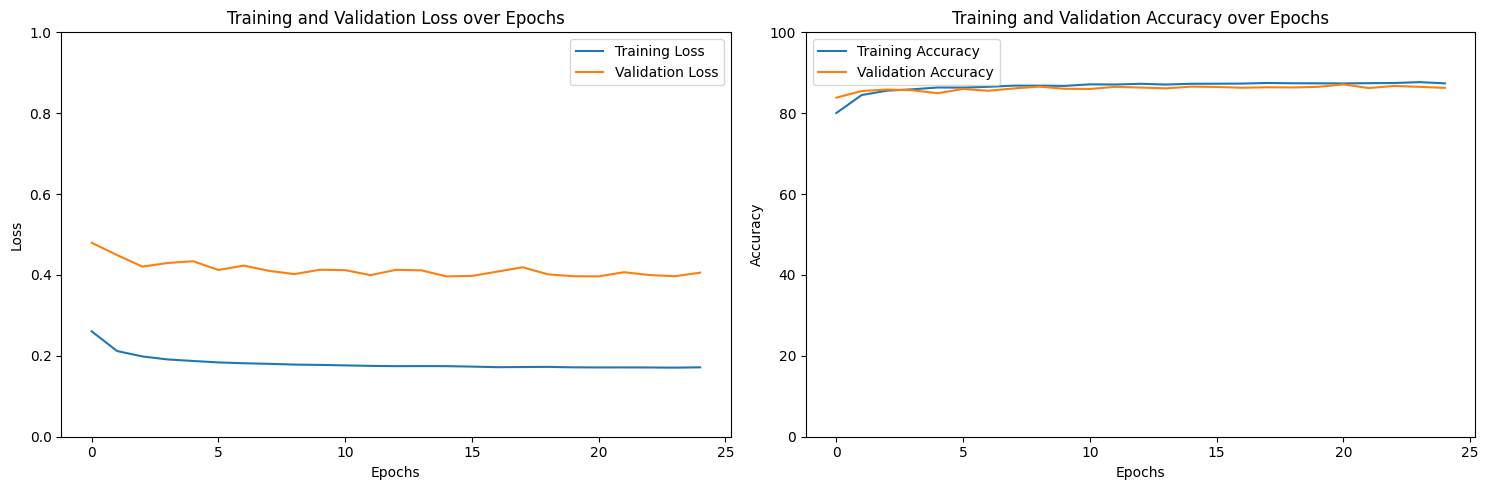

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()